# Stocks news ingestion

> <b> Steps </b>
> * [project creation and prerequisits](#project-creation-and-prerequisits)
> * [Deploying sentiment analysis serving function from the function marketplace](#Deploying-sentiment-analysis-serving-function-from-the-function-marketplace)
> * [Creating a feature set and declaring the graph](#Creating-a-feature-set-and-declaring-the-graph)
> * [Dummy ingestion, Deploying ingestion service and getting ingestion endpoint](#Dummy-ingestion,-Deploying-ingestion-service-and-getting-ingestion-endpoint)
> * [Testing ingestion service](#Testing-ingestion-service)
> * [Creating scheduled mlrun job to invoke our function every time delta](#Creating-scheduled-mlrun-job-to-invoke-our-function-every-time-delta)

## project creation and prerequisits

In [1]:
# !/User/align_mlrun.sh

In [2]:
# install prerequsits 
# prerequisits for the notebook is installing 2 packages yfinance yahoo_fin for uploading stocks data 
import importlib.util
import IPython

def install_missing_packages(packages):
    install_flag = False
    for package in packages:
        spec = importlib.util.find_spec(package)
        if spec is None:
            %pip install {package}
            install_flag = True
        else:     
            print("package {} installed".format(package))
        if install_flag:            
            print ("restarting kernerl due to package install")
            IPython.Application.instance().kernel.do_shutdown(True)
# For illustrative purposes.
packages  = ['yfinance', 'yahoo_fin']
install_missing_packages(packages)

package yfinance installed
package yahoo_fin installed


In [3]:
import mlrun
project = mlrun.get_or_create_project(name='stocks',user_project=True, context="src/")

> 2022-09-04 13:41:11,493 [info] Created and saved project stocks-dani: {'from_template': None, 'overwrite': False, 'context': 'src/', 'save': True}
> 2022-09-04 13:41:11,494 [info] created project stocks and saved in MLRun DB


In [4]:
NUMBER_OF_STOCKS = 10

In [5]:
import os

# getting the sentiment analysis pretrained model (433M might take a while)
if not os.path.exists('src/model.pt'): 
    os.makedirs('src',exist_ok=True)
    print('getting model')
    !wget -O src/model.pt https://iguazio-sample-data.s3.amazonaws.com/models/model.pt 

getting model
--2022-09-04 13:41:12--  https://iguazio-sample-data.s3.amazonaws.com/models/model.pt
Resolving iguazio-sample-data.s3.amazonaws.com (iguazio-sample-data.s3.amazonaws.com)... 52.217.170.241
Connecting to iguazio-sample-data.s3.amazonaws.com (iguazio-sample-data.s3.amazonaws.com)|52.217.170.241|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 433298364 (413M) [application/x-www-form-urlencoded]
Saving to: ‘src/model.pt’

src/model.pt        100%[===================>] 413.22M  3.61MB/s    in 2m 28s  

2022-09-04 13:43:40 (2.80 MB/s) - ‘src/model.pt’ saved [433298364/433298364]



## Deploying sentiment analysis serving function from the function marketplace

In [6]:
model_location = os.path.abspath('src/model.pt')
sentiment_analysis_serving = mlrun.import_function('hub://sentiment_analysis_serving').apply(mlrun.auto_mount())
sentiment_analysis_serving.add_model('sentiment_analysis_model', model_path=model_location,
                                      class_name='SentimentClassifierServing')

# sentiment_analysis_serving.with_http() # needed to provide http-endpoint to our serving graph

sentiment_analysis_serving.spec.readiness_timeout = 3600
address = sentiment_analysis_serving.deploy()
print(address)

> 2022-09-04 13:43:41,372 [info] Starting remote function deploy
2022-09-04 13:43:44  (info) Deploying function
2022-09-04 13:43:44  (info) Building
2022-09-04 13:43:44  (info) Staging files and preparing base images
2022-09-04 13:43:44  (info) Building processor image
2022-09-04 13:47:20  (info) Build complete
2022-09-04 13:49:30  (info) Function deploy complete
> 2022-09-04 13:49:30,905 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-stocks-dani-sentiment-analysis-serving.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['stocks-dani-sentiment-analysis-serving-stocks-dani.default-tenant.app.vmdev94.lab.iguazeng.com/']}
http://stocks-dani-sentiment-analysis-serving-stocks-dani.default-tenant.app.vmdev94.lab.iguazeng.com/


## Creating a feature set and declaring the graph

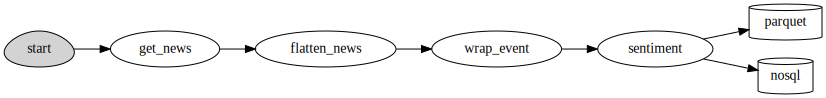

In [7]:
import mlrun.feature_store as fstore
from mlrun.feature_store.steps import DateExtractor, MapValues
import yahoo_fin.stock_info as si

# creating feature set
news_set = fstore.FeatureSet("news", 
                                 entities=[fstore.Entity("ticker")],
                                 timestamp_key='Datetime', 
                                 description="stocks news feature set")

# setting up the graph
news_set.graph \
    .to(name='get_news', handler='get_news') \
    .to("storey.steps.Flatten", name="flatten_news") \
    .to(name='wrap_event', handler='wrap_event') \
    .to("sentiment_analysis", "sentiment", full_event=True, address=address) 

news_set.set_targets(with_defaults=True) 
news_set.plot(rankdir="LR", with_targets=True)

## Dummy ingestion, Deploying ingestion service and getting ingestion endpoint

In [8]:
# ingesting dummy (A MUST) 
import os
import datetime
import pandas as pd
# because were ingesting locally, code must be present !
from src.news import *

name = os.environ['V3IO_USERNAME']
now = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

fstore.ingest(news_set,
              pd.DataFrame.from_dict({'ticker':[name],
                                      'Datetime': now,
                                      'n_stocks':NUMBER_OF_STOCKS}))

,Datetime,published,summary,title,sentiment
ticker,,,,,
A,2022-09-02 10:20:10,2022-09-02 10:20:10,Style Box ETF report for IMCG,Should iShares Morningstar MidCap Growth ETF I...,1.0
A,2022-09-01 12:00:00,2022-09-01 12:00:00,SANTA CLARA Calif September 01 2022Agilent Tec...,Agilent Collaborates with METTLER TOLEDO to Re...,0.0
A,2022-08-30 12:42:12,2022-08-30 12:42:12,Investors need to pay close attention to Agile...,Implied Volatility Surging for Agilent Technol...,0.5
A,2022-08-29 10:00:06,2022-08-29 10:00:06,Today’s article discusses seven stocks on the ...,7 Stocks on the Cusp of a Major Move Higher,0.5
A,2022-08-25 16:46:04,2022-08-25 16:46:04,Zuoras ZUO secondquarter fiscal 2023 results r...,Zuora ZUO Q2 Earnings Beat Estimates Revenues ...,1.0
...,...,...,...,...,...
ADBE,2022-08-22 12:15:48,2022-08-22 12:15:48,When looking for the best artificial intellige...,Artificial Intelligence Stocks To Watch Big Te...,1.0
ADBE,2022-08-22 09:10:00,2022-08-22 09:10:00,Investors would be wise to look beyond the hea...,2 Top Growth Stocks to Buy Right Now and Hold ...,1.0
ADBE,2022-08-20 11:17:00,2022-08-20 11:17:00,Now that technology exists to make lifelike re...,This Bold Unity Software Prediction Could Make...,0.0


In [9]:
# Deploying ingestion service
# Define the HTTP Source to_dictable the HTTP trigger on our function and expose the endpoint.
# There is an option to declare key and timestamp inside the http source (here we dont send data through the http hence not needed)
http_source = mlrun.datastore.sources.HttpSource()
news_set.spec.source = http_source

# code_to_function our mlrun wrapped function to deploy the ingestion pipeline on.
# the serving runtimes enables the deployment of our feature set's computational graph
function = mlrun.code_to_function(name='get_news',kind='serving',image='mlrun/mlrun', requirements=['yahoo_fin','graphviz'], filename='src/news.py')

function.spec.readiness_timeout = 3600

run_config = fstore.RunConfig(function=function, local=False).apply(mlrun.mount_v3io())

# Deploying
news_set_endpoint = fstore.deploy_ingestion_service(featureset=news_set, run_config=run_config)

> 2022-09-04 13:52:42,440 [info] Starting remote function deploy
2022-09-04 13:52:42  (info) Deploying function
2022-09-04 13:52:42  (info) Building
2022-09-04 13:52:42  (info) Staging files and preparing base images
2022-09-04 13:52:42  (info) Building processor image
2022-09-04 13:53:58  (info) Build complete
2022-09-04 13:54:14  (info) Function deploy complete
> 2022-09-04 13:54:15,057 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-stocks-dani-get-news.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['stocks-dani-get-news-stocks-dani.default-tenant.app.vmdev94.lab.iguazeng.com/']}


## Testing ingestion service

In [10]:
import requests
import json

now = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

t = requests.post(news_set_endpoint,json={'ticker':['news'],
                                                 'Datetime': now,
                                                 'n_stocks':NUMBER_OF_STOCKS})
t.text

'{"id": "ae068105-e069-4281-a59b-7faa64fbb540"}'

## Creating scheduled mlrun job to invoke our function every time delta

In [11]:
%%writefile src/invoker.py

import requests
import datetime

def ingestion_service_invoker(endpoint): 
    now = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    
    t = requests.post(endpoint,json={'ticker':['news'],
                                     'Datetime': now,
                                     'n_stocks':4})

Overwriting src/invoker.py


In [12]:
# specifying '0 8 * * *' as schedule will trigger the function every day at 08:00 AM
fn = mlrun.code_to_function(name='ingestion_service_news',kind='job',image='mlrun/mlrun',handler='ingestion_service_invoker', filename='src/invoker.py')
fn.run(params={'endpoint':news_set_endpoint}, schedule='0 */1 * * *')

> 2022-09-04 13:54:15,335 [info] starting run ingestion-service-news-ingestion_service_invoker uid=acb90f0cc3144a249d80a8b182030e79 DB=http://mlrun-api:8080
> 2022-09-04 13:54:15,597 [info] task scheduled, {'schedule': '0 */1 * * *', 'project': 'stocks-dani', 'name': 'ingestion-service-news-ingestion_service_invoker'}
